In [1]:
%pylab notebook
from glob import glob

def draw(gid, x_o=0, y_o=0, bb=False, add_label=False):
    ''' draw a glyp at certain position '''
    gg = glyphs[gid]
#     w = gg[-1]
    
    l, r = gg[0:2]
    xx = gg[0::2][1:].astype(float)
    yy = gg[1::2][1:].astype(float)
    
    g_inds = (xx == -50) & (yy == 0)
    xx[g_inds] = nan
    yy[g_inds] = nan
    
    x_o -= l
    
    plot(xx + x_o, -yy + y_o, '-', lw=1)
    if bb:
        vlines([0 + x_o], y_o - 20, y_o - 15, color='red')
        vlines([l + x_o], y_o - 20, y_o - 15, color='grey')
        vlines([r + x_o], y_o - 20, y_o - 15, color='grey')
    if add_label:
        text(x_o, y_o - 30, f'{gid:04x}', color='grey', ha='center', size="x-small")
    return r - l

def expand_range(mm):
    ''' expand a font mapping containing ranges '''
    if type(mm) is str:
        mm = mm.replace('\n', ' ').split()
    mm_ = []
    for m in mm:
        if '-' in m:
            tmp = m.split('-')
            rr = range(int(tmp[0]), int(tmp[1]) + 1)
            mm_ += rr
        else:
            mm_.append(int(m))
    return mm_

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Load hershey glyphs

In [2]:
with open('./hershey') as f:
    lines_ = f.readlines()

lines = []
for d in lines_:
    d = d.rstrip('\n')
    try:
        k = int(d[0:5])  # glyph id
        n = int(d[5:8])  # number of vertices
        lines.append(d)
    except ValueError:
        if len(d) > 0:
            lines[-1] += d
print(len(lines_), len(lines))

glyphs = {}
for d in lines:
    k = int(d[0:5])  # glyph id
    n = int(d[5:8])  # number of vertices
    tmp = [ord(c) - ord('R') for c in d[8:]]
    assert(len(tmp) == n * 2)
    # we do width at the end     
#     l, r, *tmp_ = tmp
#     tmp_.append(r - l)
    glyphs[k] = array(tmp)

2324 1597


# Plot ALL glyphs

<IPython.core.display.Javascript object>


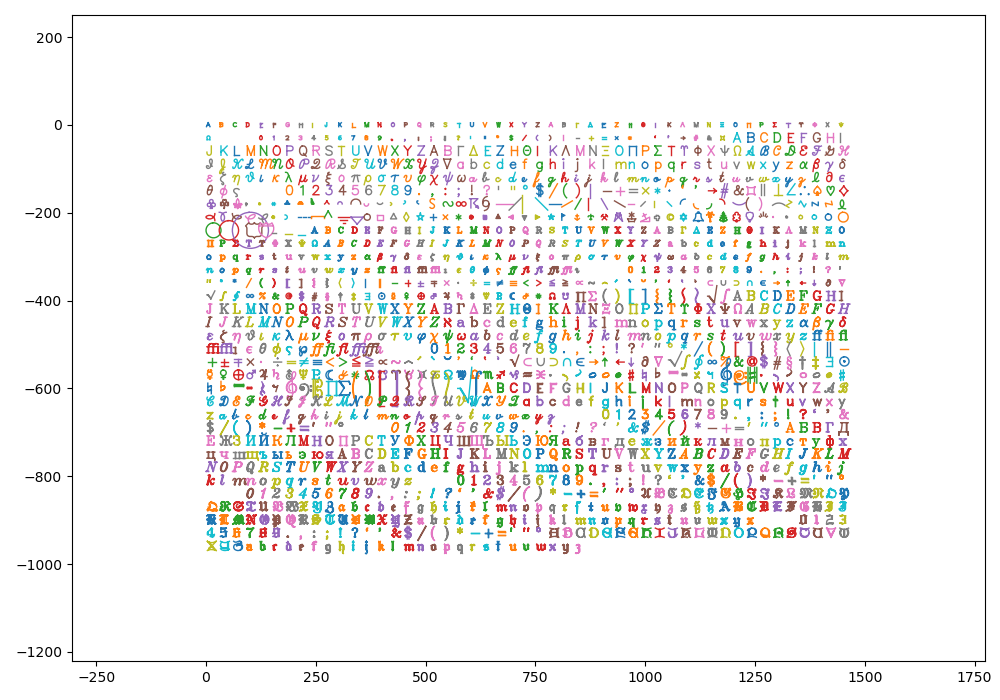

In [5]:
close('all')
figsize(10, 7)
axis('equal')

xp = 0
yp = 0
stp = 30
for k in sorted(glyphs.keys()):
    r = draw(k, xp, yp)
    xp += stp
    if (xp > stp * 48):
        xp = 0
        yp -= stp
tight_layout()

# Load all font mappings

In [12]:
remaining_keys = set(glyphs.keys())

maps = {}
for fn in glob("ascii-mapping/*.hmp"):
    with open(fn) as f:
        dat = expand_range(f.read(-1))
    fn_ = fn.split('/')[-1][:-4]
    maps[fn_] = dat
    remaining_keys.difference_update(dat)

maps["symbols"] = remaining_keys
    
maps.keys()

dict_keys(['italict', 'romancs', 'romand', 'scriptc', 'romanp', 'romant', 'greekcs', 'romanc', 'italiccs', 'gothgrt', 'romans', 'greekp', 'cyrilc', 'gothgbt', 'italicc', 'greeks', 'scripts', 'greekc', 'gothitt', 'symbols'])

# Plot index sheets

<IPython.core.display.Javascript object>


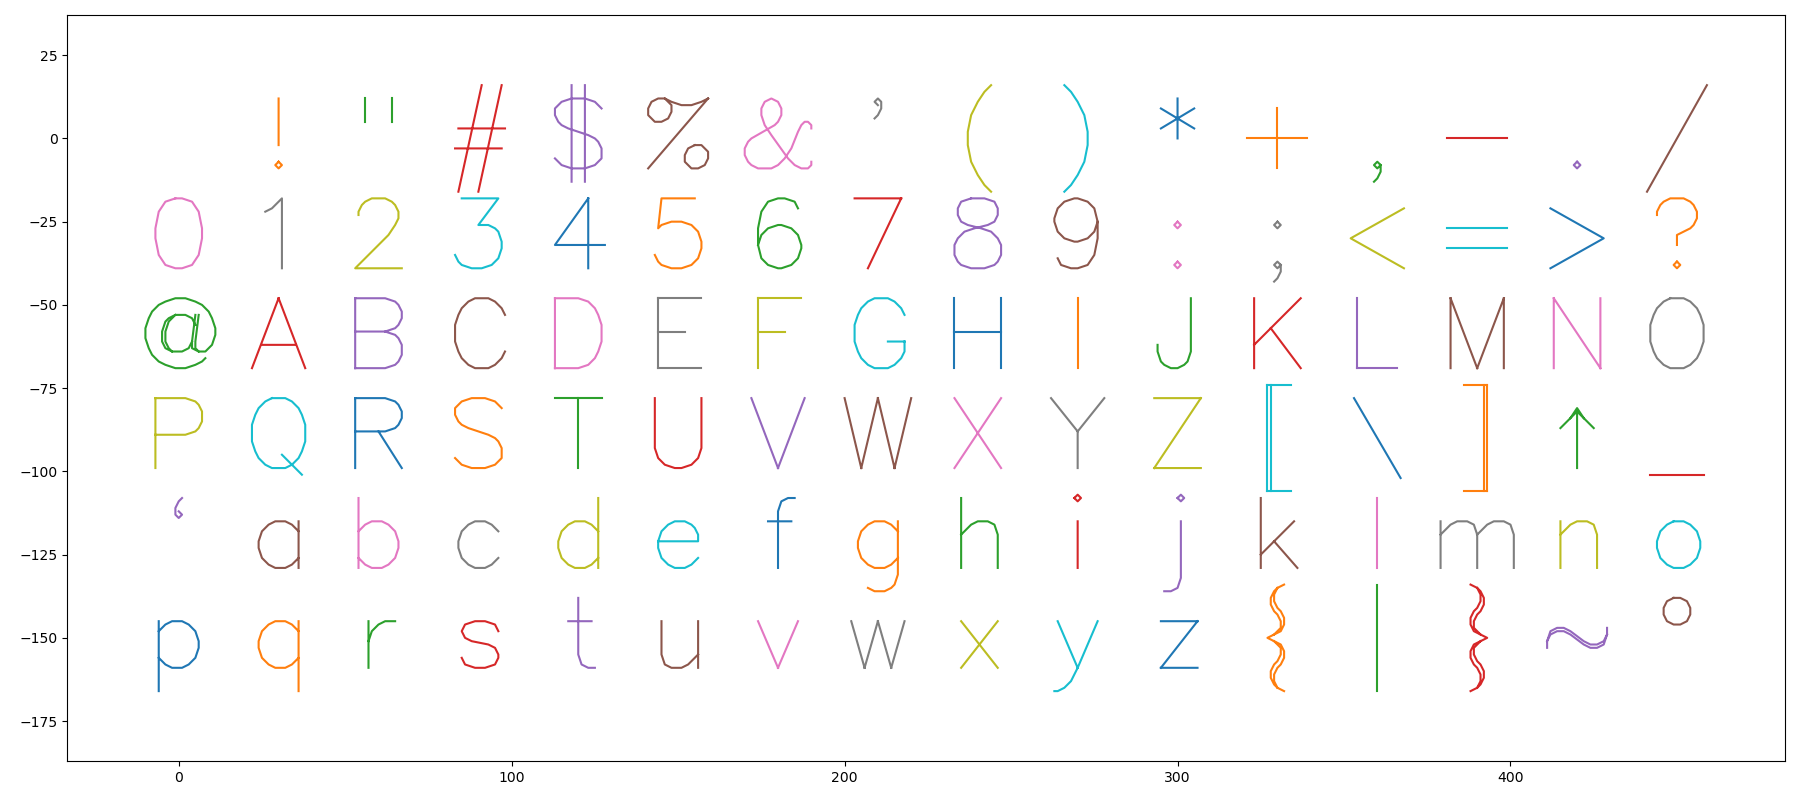

In [190]:
for m in maps.keys():
#     m = 'romans'
    figure()
    figsize(18, 8)
    axis('equal')
    tight_layout()

    xp = 0
    yp = 0
    stp = 30
    for k in maps[m]:
        r = draw(k, xp, yp)
        xp += stp
        if (xp >= stp * 16):
            xp = 0
            yp -= stp
#     break
    savefig(f'ascii-mapping/{m}.png')

# Leftovers (symbols)

<IPython.core.display.Javascript object>


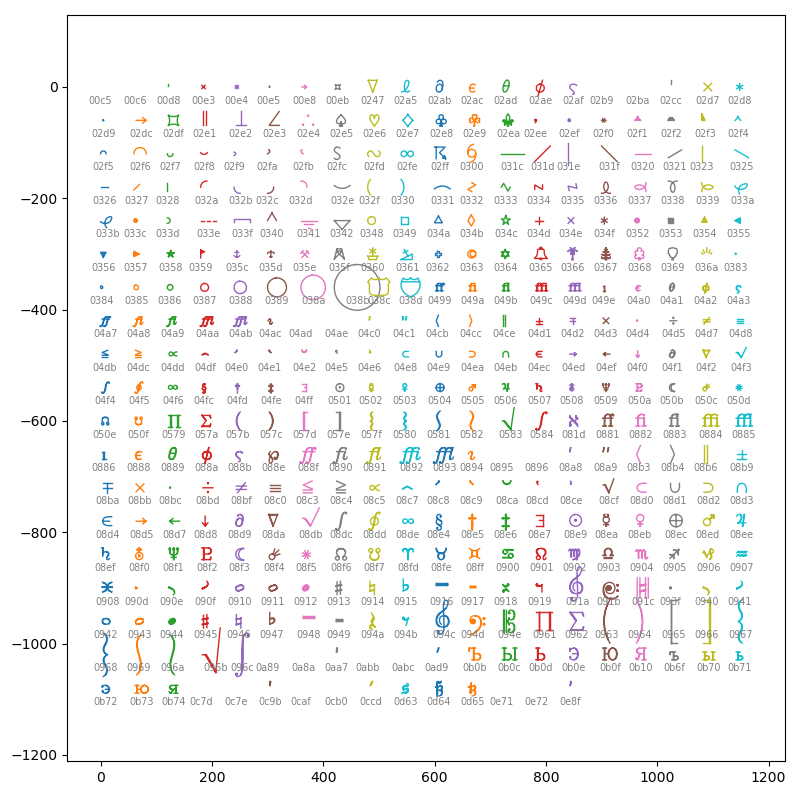

In [13]:
figure()
figsize(8, 8)
axis('equal')
tight_layout()

xp = 0
yp = 0
stp = 60
for k in maps["symbols"]:
    r = draw(k, xp, yp, add_label=True)
    xp += stp
    if (xp >= stp * 20):
        xp = 0
        yp -= stp
#     break
# savefig(f'ascii-mapping/remaining.png', dpi=300)

# Test spacing between glyphs

The cursor is at the left edge of the glyph.

We move by -l to reach the center

We draw the glyph

We move by r to reach the right edge of the glyph

<IPython.core.display.Javascript object>


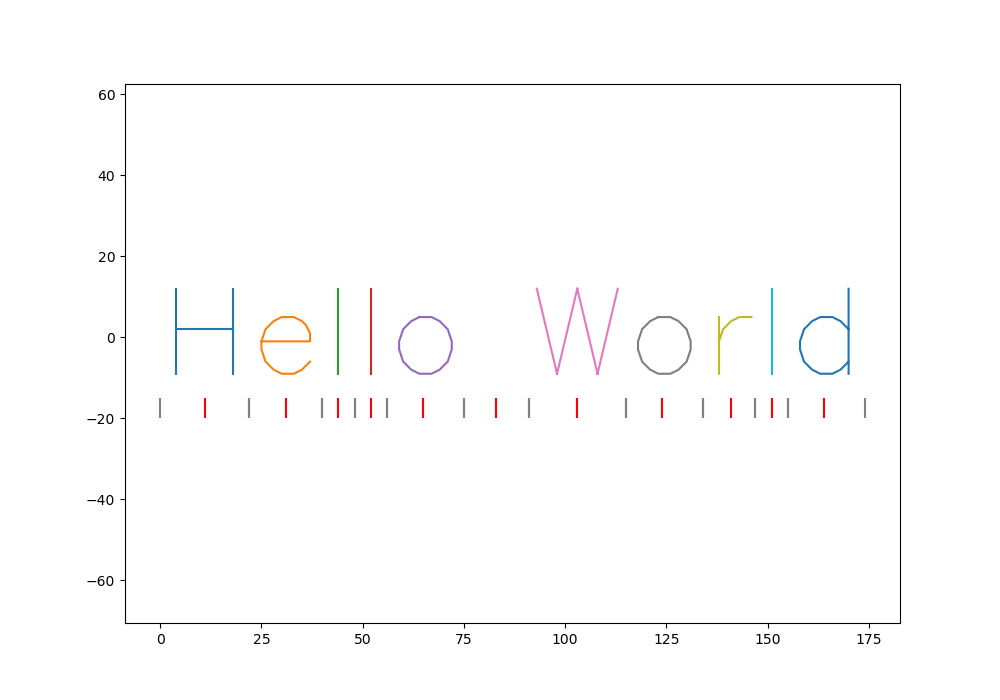

In [120]:
close('all')
axis('equal')

m = maps['romans']

x_o = 0
for c in "Hello World":
    r = draw(m[ord(c) - 0x20], x_o, 0, bb=True)
    x_o += r

# C-code generation

In [11]:
from font_helpers import CoordinateEncoder, T_GOTO, T_LINETO, print_table

In [ ]:
out_name = Path(args.font_file).with_suffix(".c")
name = tt["name"].getBestFullName().lower()
name = re.sub('[^A-Za-z0-9]+', '_', name)

In [38]:
def print_table(vals, w=24, w_v=3, f=None):
    ll = len(vals) - 1
    for i, g in enumerate(vals):
        if i > 0 and (i % w) == 0:
            print(file=f)
        print(f'{g:{w_v}d}', end='', file=f)
        if i < ll:
            print(',', end='', file=f)
    print('\n};\n', file=f)

def print_tables(name, f=None):
    all_glyphs = []
    g_lens = []
    for gid in maps[name]:
        all_glyphs += glyphs[gid].tolist()
        g_lens.append(len(glyphs[gid]))
    all_glyphs = array(all_glyphs, dtype=int8)

    print(f'static const int8_t h_{km}_glyphs[{len(all_glyphs)}] = {{', file=f)
    print_table(all_glyphs, 24, 3, f=f)

    g_inds = cumsum(g_lens)
    print(f'static const uint16_t h_{km}_inds[{len(g_inds)}] = {{', file=f)
    print_table(g_inds, 16, 5, f=f)

# Convert to internal glyph format

In [14]:
to_export = [
#     'cyrilc',
#    'gothgbt',
#    'gothgrt',
#    'gothitt',
#     'greekc',
     'greekcs',
#     'greekp',
#     'greeks',
#    'italicc',
    'italiccs',
#    'italict',
#    'romanc',
    'romancs',
#    'romand',
#    'romanp',
    'romans',
#    'romant',
    'scriptc',
    'scripts',
    'symbols'
]

## Make one big table with all needed glyphs

In [20]:
all_gs = set()
for name in to_export:
    all_gs.update(maps[name])
all_gs = sorted(all_gs)

In [41]:
all_bs = bytes()
glyph_props = []

for gl_index in all_gs:
    ce = CoordinateEncoder()
    
    pts = glyphs[gl_index]
    l, r = pts[0:2]
    cmd = T_GOTO
    bs = bytes()

    for pt in pts[2:].reshape([-1, 2]):
        if (pt == (-50, 0)).all():
            cmd = T_GOTO
            continue
            
        pt[0] -= l
        bs += ce.encode(pt, cmd << 4)
        cmd = T_LINETO
            
    glyph_props.append({
        "end_index": len(all_bs) + len(bs),
        "adv_w": r - l,
    })
    all_bs += bs

In [46]:
with open("hershey.c", 'w') as f:
    print(f'''\
#include <stdint.h>
#include <stdio.h>
#include <font_draw.h>
// -----------------------------------
//  Hershey fonts
// -----------------------------------

static const uint8_t glyphs[{len(all_bs)}] = {{''', file=f)
    print_table(all_bs, f=f)
    
    print(f'''\
// GLYPH DESCRIPTION
static const glyph_dsc_t glyph_dsc[{len(glyph_props)}] = {{''', file=f)
    for line in glyph_props:
        print("    {" + ", ".join([f'.{k} = {v:5d}' for k, v in line.items()]) + f"}},", file=f)
    print("};\n", file=f)

    # unicode mapping tables
    n_cp_table_entries = len(cp_set) - n_ascii
    cp_table_name = "NULL"
    if n_cp_table_entries > 0:
        cp_table_name = f"code_points_{name}"
        print(f'const unsigned {cp_table_name}[{n_cp_table_entries}] = {{', file=f)
        print_table(cp_set[n_ascii:], w=19, w_v=6, f=f)


#     # index table of all fonts    
#     print('font_t* f_all[] = {', file=f)
#     for km in to_export + ['arc']:
#         print(f'  &f_{km},', file=f)
#     print('};', file=f)
        
# with open("../src/font_data.h", 'w') as f:
#     print('''\
# #ifndef FONT_DATA_H
# #define FONT_DATA_H
# #include <stdint.h>
# #include <font_draw.h>

# // gothgr  Gothic German
# // gothgb  Gothic English
# // gothit  Gothic Italian

# // p       Plain (very small, no lower case)
# // s       Simplex (plain, normal size, no serifs)
# // d       Duplex (normal size, no serifs, doubled lines)
# // c       Complex (normal size, serifs, doubled lines)
# // t       Triplex (normal size, serifs, tripled lines)
# // cs      Complex Small (Complex, smaller than normal size)
# ''', file=f)
#     print(f'#define N_FONTS {len(to_export) + 1}\n', file=f)
    
#     for i, km in enumerate(to_export + ['arc']):
#         s = f'extern font_t f_{km};'
#         print(f'{s:<32s}  // {i}', file=f)
    
#     print('\nextern font_t* f_all[];\n', file=f)
#     print('#endif', file=f)

lengt 2 means there is only the left and right value and nothing to draw, eg space

In [242]:
def get_inds(c):
    ''' generate the start and end indices into the glyph table '''
    if c <= 0:
        return 0, start_inds[0]
    return start_inds[c - 1], start_inds[c]